# Analyse brute des données quotidiennes publiques covid19  France et régions


[Dernier Rapport au format pdf sur le site github](https://github.com/grouss/COVID19France/raw/master/COVID19_France_Regions.pdf)

In [29]:
run -i function.py

In [30]:
run -i load.py

Read  ./RawData/donnees-hospitalieres-classe-age-covid19-2021-08-09-19h09.csv
Read  ./RawData/donnees-hospitalieres-nouveaux-covid19-2021-08-09-19h09.csv


## Chiffres des hospitalisations et des décès (Cumulés en France)

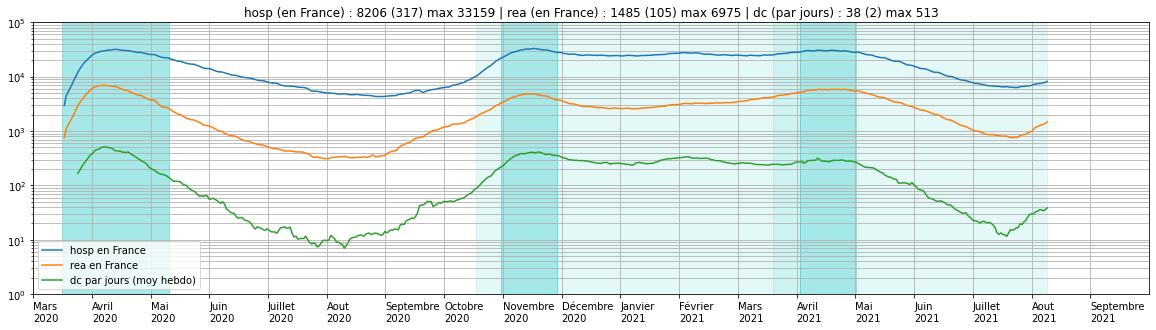

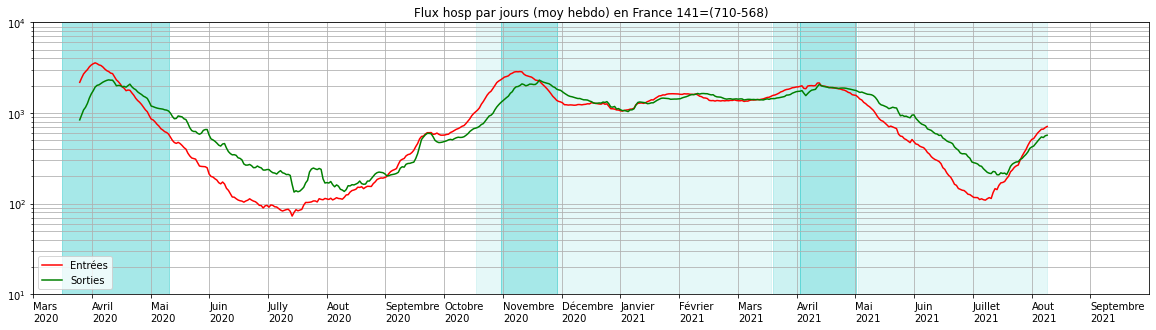

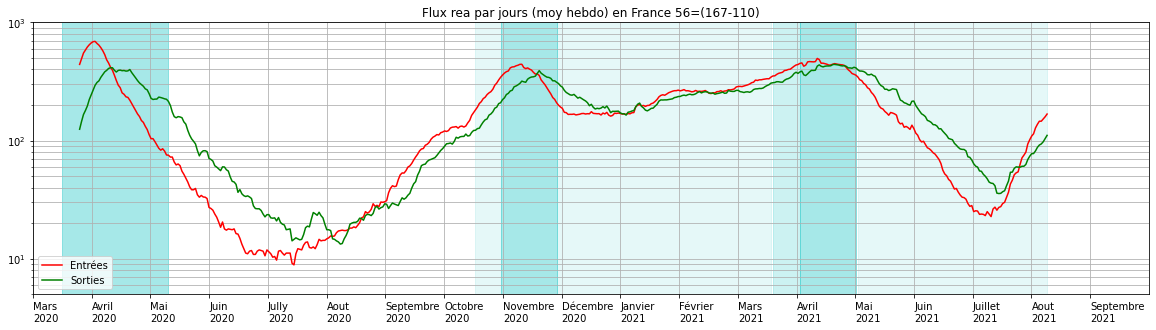

In [31]:
DisplayFrance()

## Chiffres des hospitalisations et des décès (par régions)


ILE DE FRANCE (0 à 99+ ans)


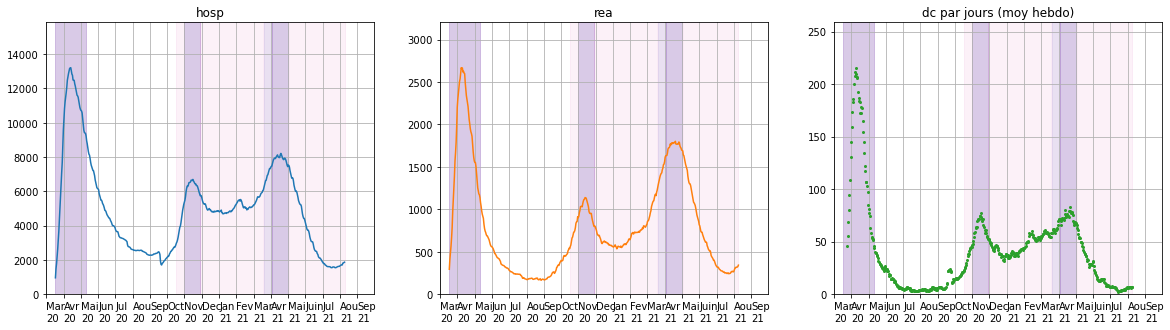


CENTRE VAL DE LOIRE (0 à 99+ ans)


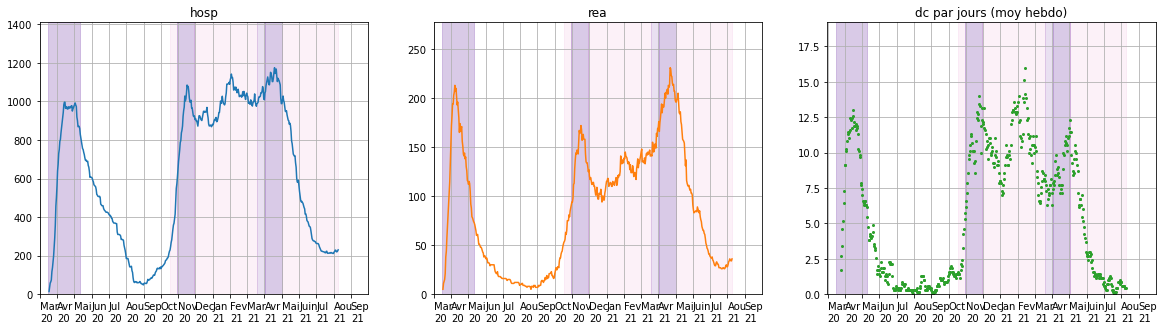


BOURGOGNE FRANCHE COMTE (0 à 99+ ans)


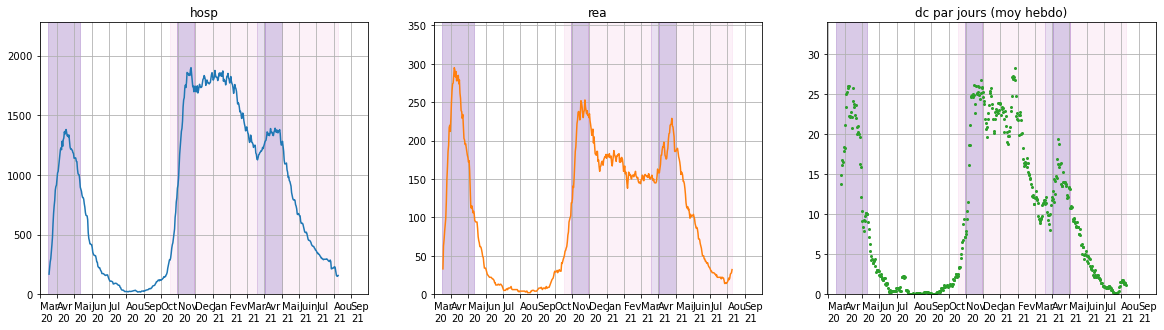


NORMANDIE (0 à 99+ ans)


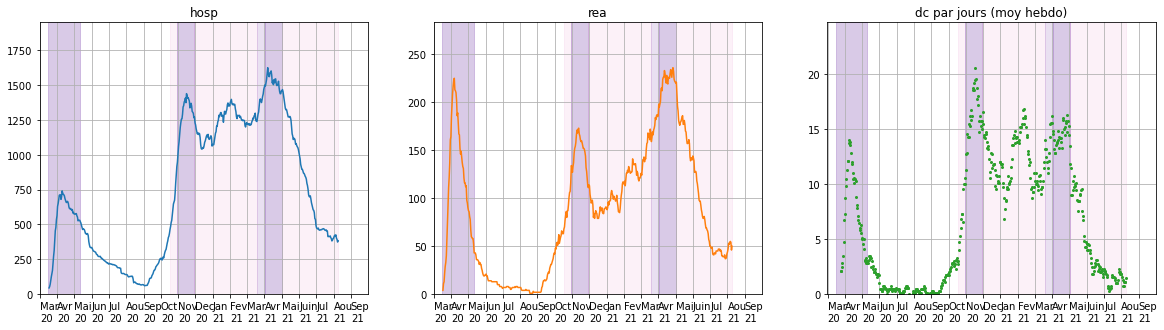


HAUTS DE FRANCE (0 à 99+ ans)


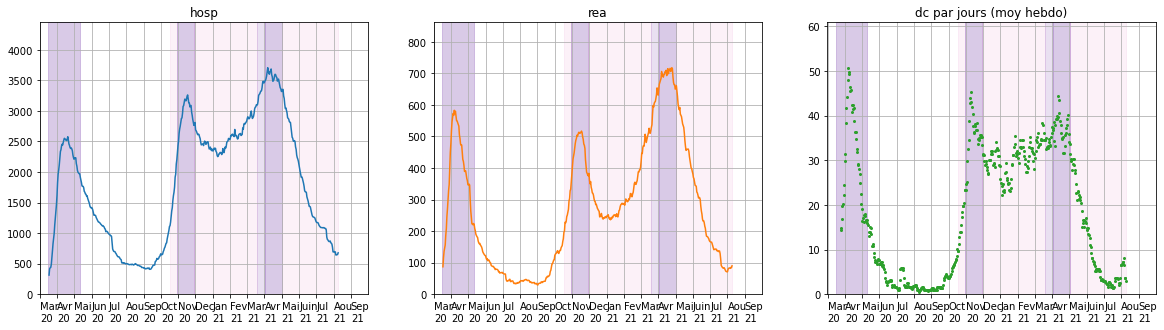


GRAND EST (0 à 99+ ans)


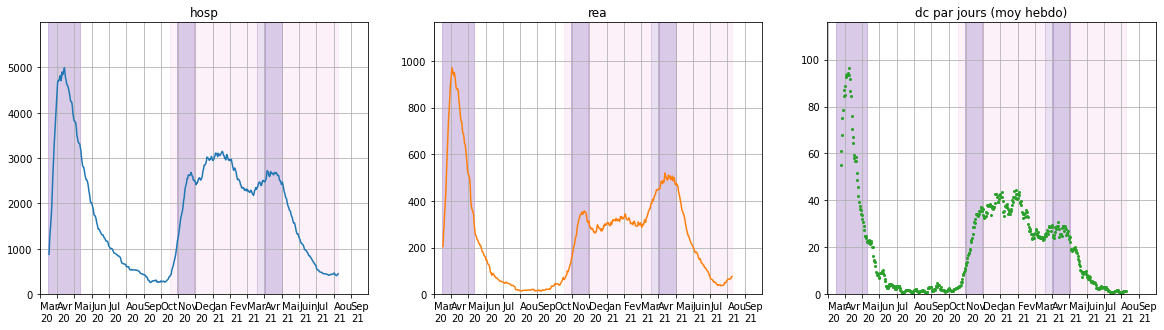


PAYS DE LA LOIRE (0 à 99+ ans)


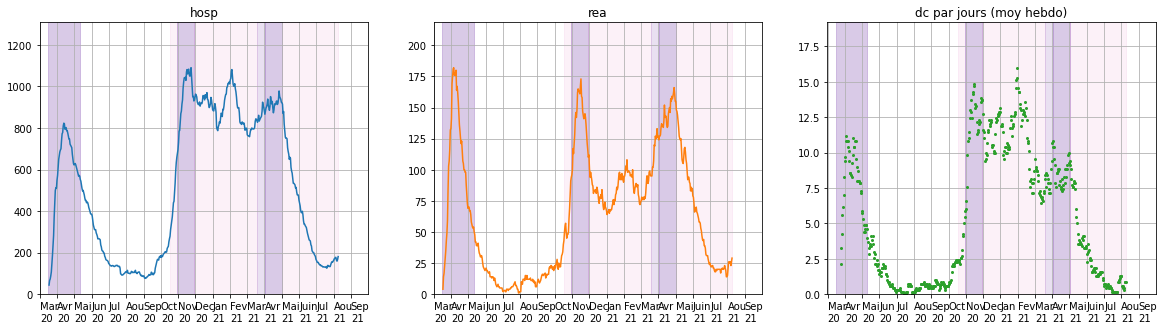


BRETAGNE (0 à 99+ ans)


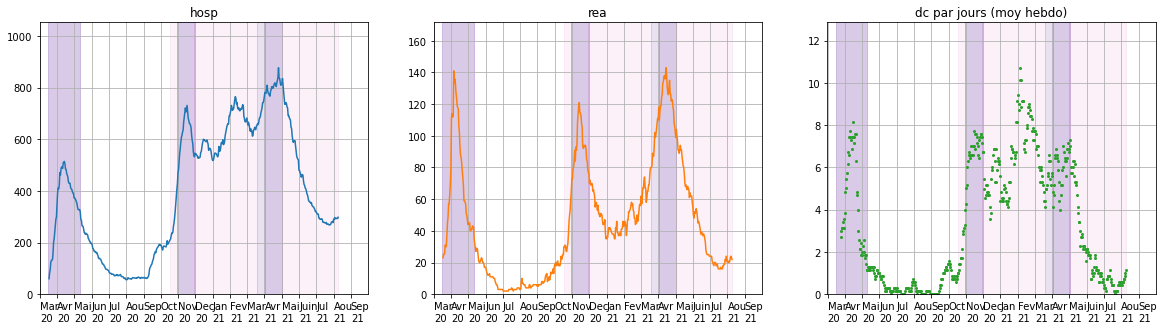


NOUVELLE AQUITAINE (0 à 99+ ans)


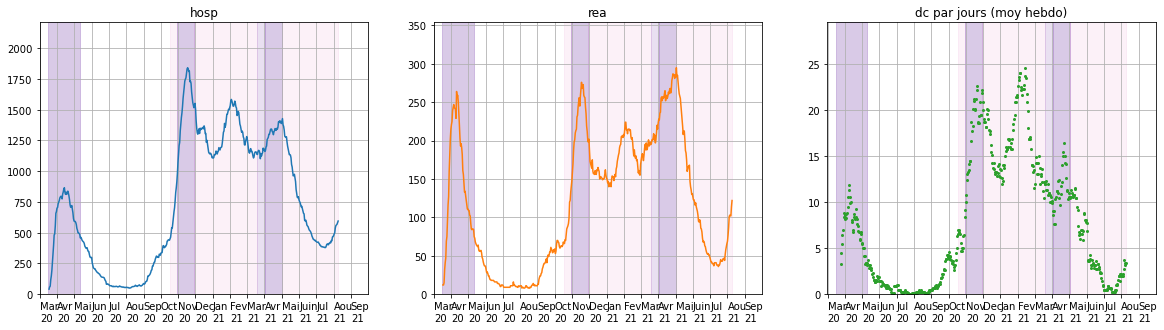


OCCITANIE (0 à 99+ ans)


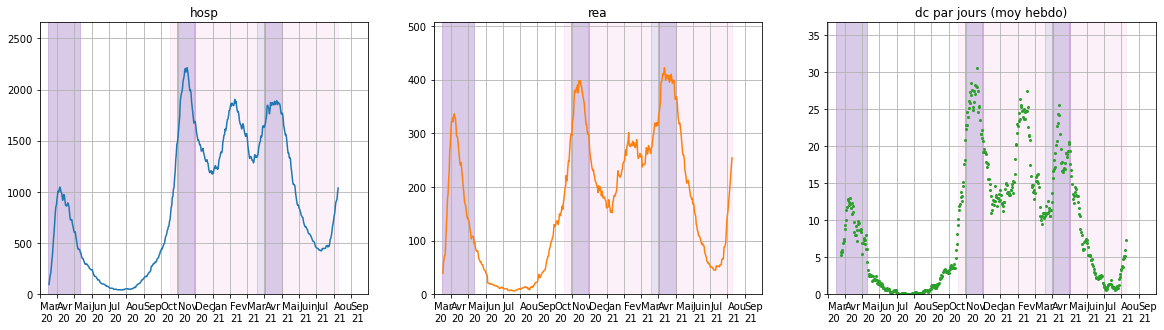


AUVERGNE RHONE ALPES (0 à 99+ ans)


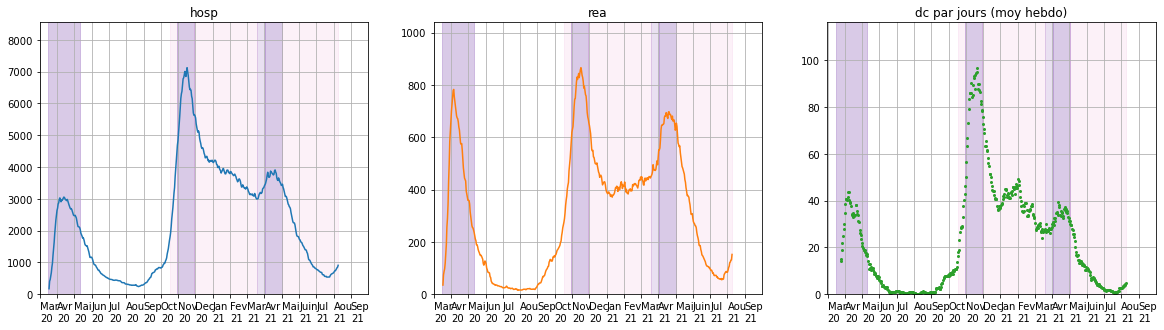


PROVENCE ALPES COTE D AZUR (0 à 99+ ans)


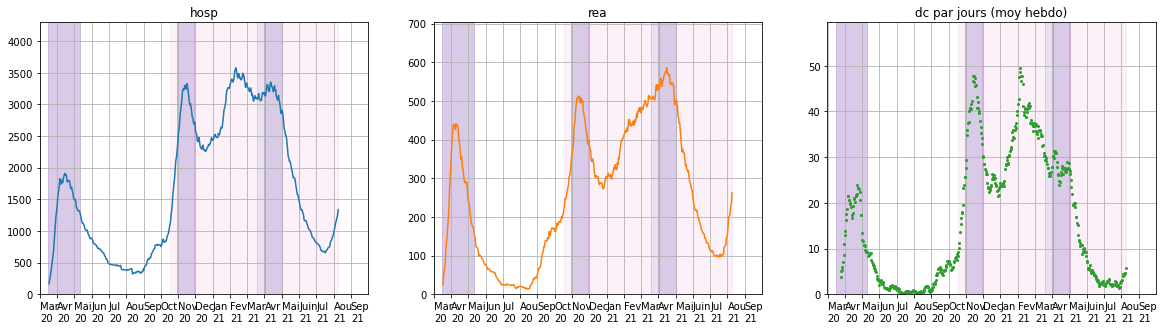


CORSE (0 à 99+ ans)


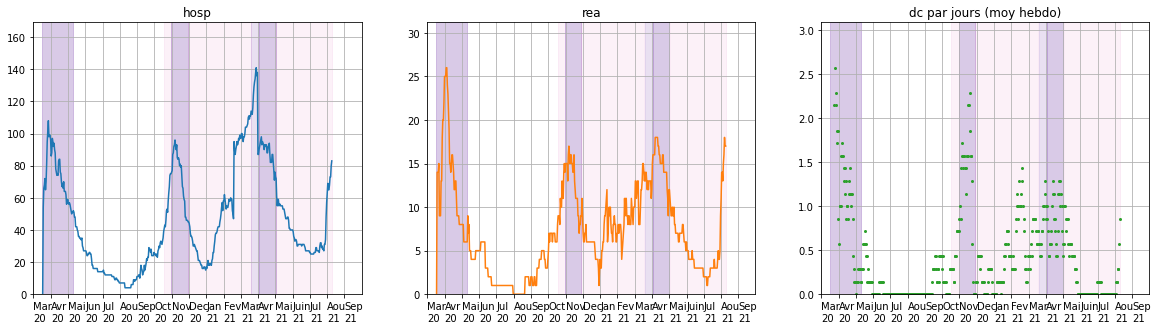

In [32]:
for reg in region:
    DisplayRegions(reg)

## Chiffres des hospitalisations et des décès (par tranches d'age)


0 à 99+ ans
 Max   hosp : 33159 | 1ère Vague :31990 | 2ème Vague :33159 |
 Max   rea  :  6975 | 1ère Vague : 6975 | 2ème Vague : 5876 |
 Max   dc   :   513 | 1ère Vague :  513 | 2ème Vague :  411 |
 Total dc   : 83897 | 1ère Vague: 18618 | 2ème Vague :65278 |


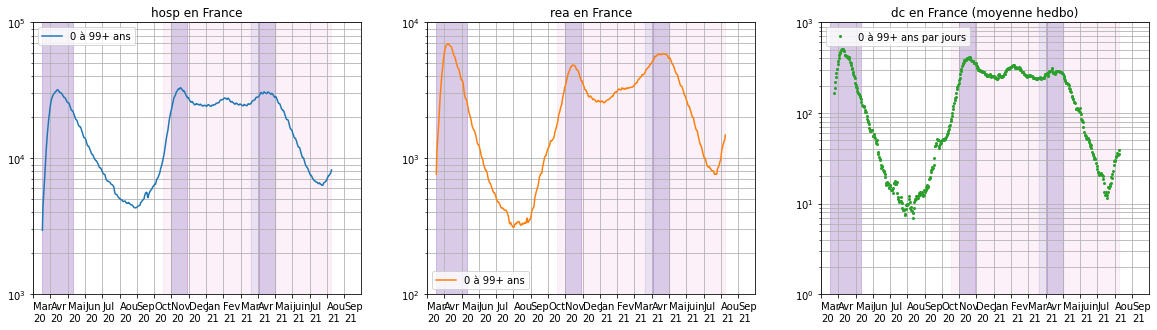


0 à 9 ans
 Max   hosp :   109 | 1ère Vague :  109 | 2ème Vague :  109 |
 Max   rea  :    26 | 1ère Vague :   26 | 2ème Vague :   19 |
 Max   dc   :     0 | 1ère Vague :    0 | 2ème Vague :    0 |
 Total dc   :     5 | 1ère Vague:     3 | 2ème Vague :    2 |


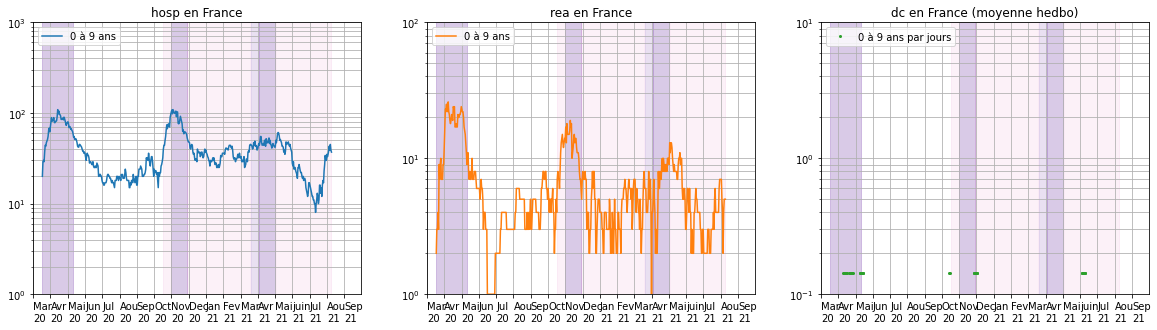


10 à 19 ans
 Max   hosp :   105 | 1ère Vague :   89 | 2ème Vague :  105 |
 Max   rea  :    26 | 1ère Vague :   26 | 2ème Vague :   20 |
 Max   dc   :     0 | 1ère Vague :    0 | 2ème Vague :    0 |
 Total dc   :     7 | 1ère Vague:     3 | 2ème Vague :    4 |


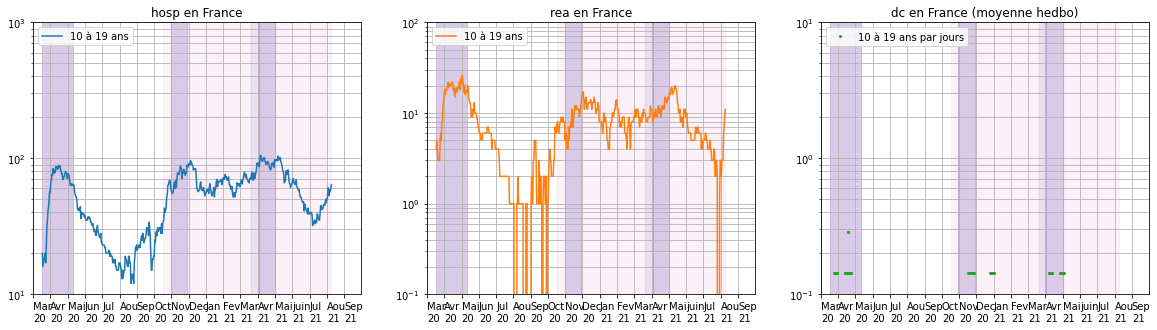


20 à 29 ans
 Max   hosp :   386 | 1ère Vague :  357 | 2ème Vague :  386 |
 Max   rea  :    66 | 1ère Vague :   66 | 2ème Vague :   66 |
 Max   dc   :     1 | 1ère Vague :    1 | 2ème Vague :    1 |
 Total dc   :    74 | 1ère Vague:    19 | 2ème Vague :   55 |


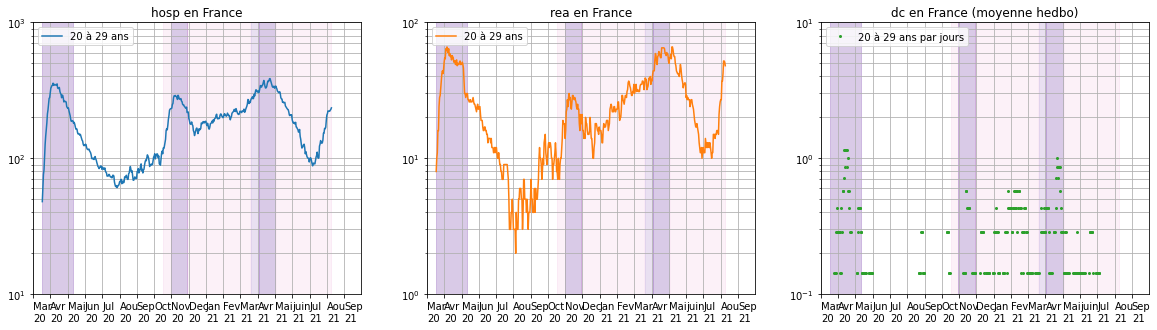


30 à 39 ans
 Max   hosp :   923 | 1ère Vague :  923 | 2ème Vague :  819 |
 Max   rea  :   233 | 1ère Vague :  233 | 2ème Vague :  184 |
 Max   dc   :     3 | 1ère Vague :    3 | 2ème Vague :    1 |
 Total dc   :   245 | 1ère Vague:    88 | 2ème Vague :  157 |


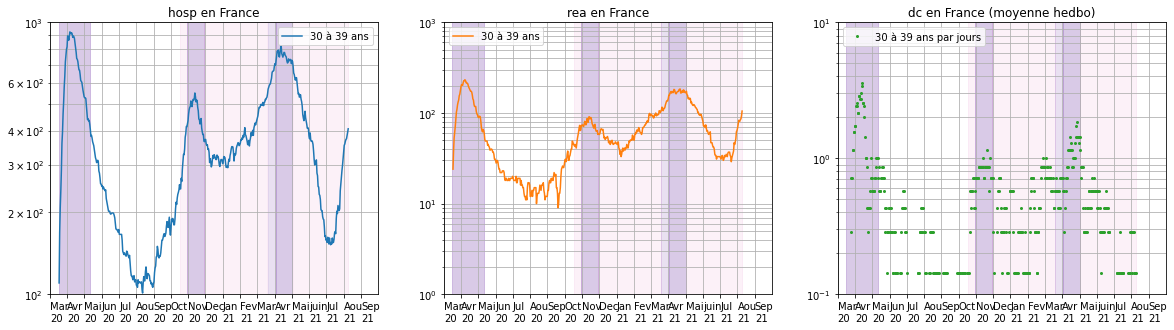


40 à 49 ans
 Max   hosp :  2001 | 1ère Vague : 2001 | 2ème Vague : 1683 |
 Max   rea  :   586 | 1ère Vague :  586 | 2ème Vague :  497 |
 Max   dc   :     7 | 1ère Vague :    7 | 2ème Vague :    5 |
 Total dc   :   800 | 1ère Vague:   228 | 2ème Vague :  572 |


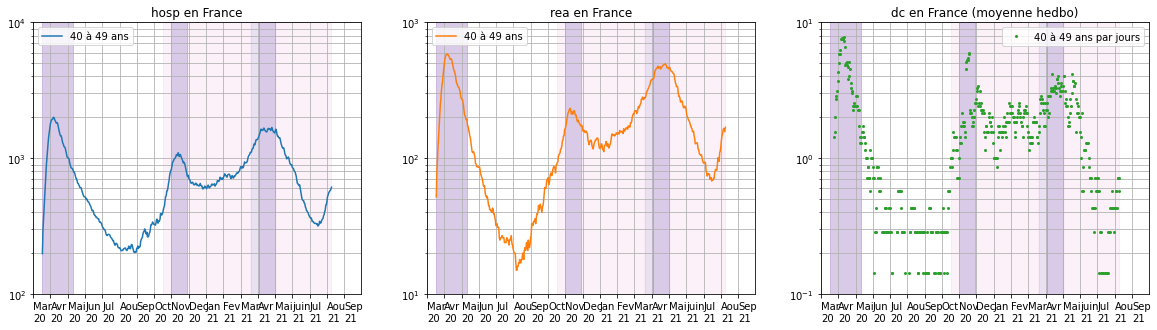


50 à 59 ans
 Max   hosp :  4221 | 1ère Vague : 4221 | 2ème Vague : 3663 |
 Max   rea  :  1519 | 1ère Vague : 1519 | 2ème Vague : 1189 |
 Max   dc   :    27 | 1ère Vague :   27 | 2ème Vague :   16 |
 Total dc   :  3008 | 1ère Vague:   884 | 2ème Vague : 2124 |


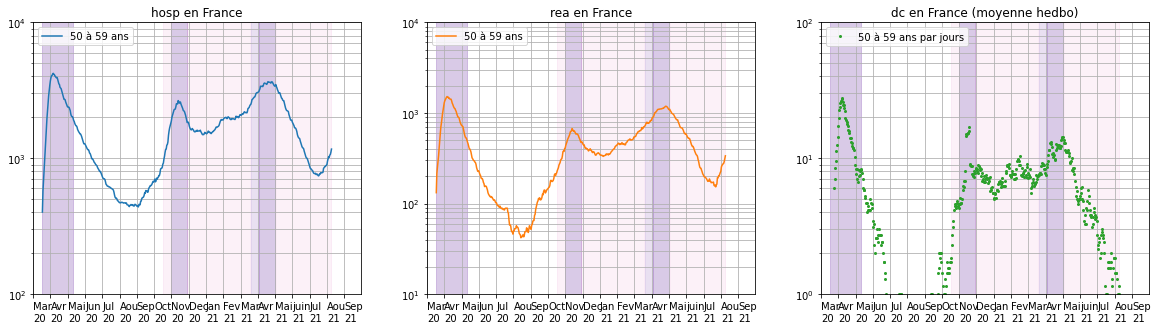


60 à 69 ans
 Max   hosp :  6210 | 1ère Vague : 6210 | 2ème Vague : 5987 |
 Max   rea  :  2307 | 1ère Vague : 2307 | 2ème Vague : 1969 |
 Max   dc   :    62 | 1ère Vague :   62 | 2ème Vague :   54 |
 Total dc   :  9193 | 1ère Vague:  2214 | 2ème Vague : 6979 |


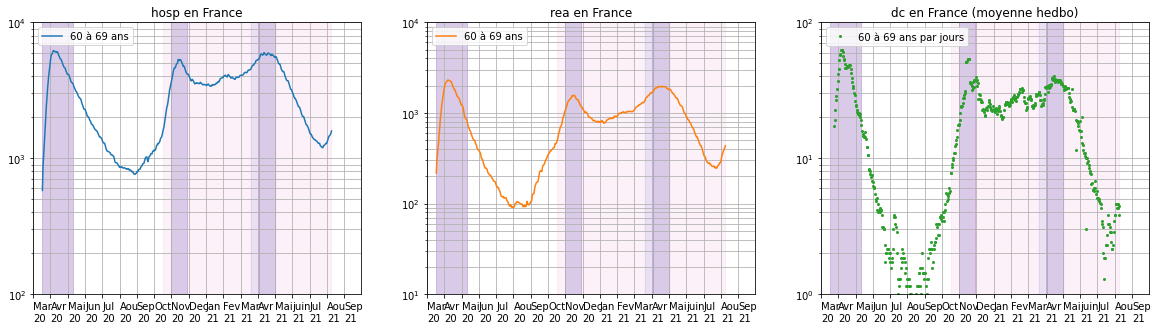


70 à 79 ans
 Max   hosp :  8223 | 1ère Vague : 7096 | 2ème Vague : 8223 |
 Max   rea  :  1882 | 1ère Vague : 1882 | 2ème Vague : 1797 |
 Max   dc   :   125 | 1ère Vague :  125 | 2ème Vague :  100 |
 Total dc   : 18949 | 1ère Vague:  4168 | 2ème Vague :14780 |


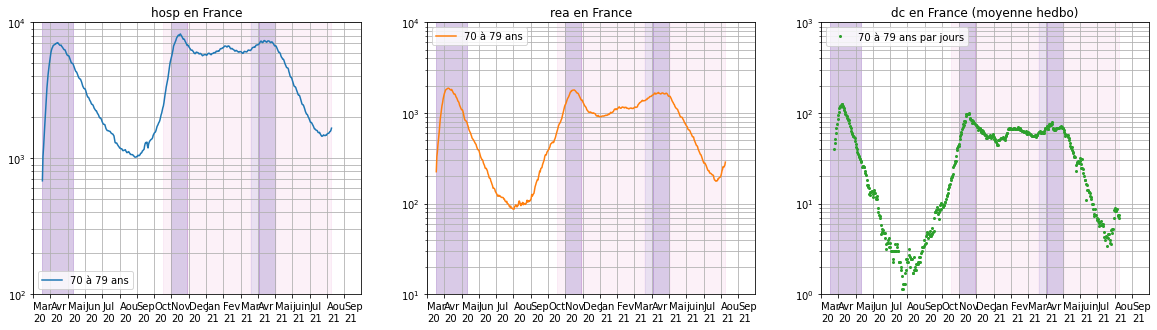


80 à 89 ans
 Max   hosp : 10267 | 1ère Vague : 7886 | 2ème Vague :10267 |
 Max   rea  :   458 | 1ère Vague :  303 | 2ème Vague :  458 |
 Max   dc   :   209 | 1ère Vague :  197 | 2ème Vague :  209 |
 Total dc   : 32326 | 1ère Vague:  6843 | 2ème Vague :25483 |


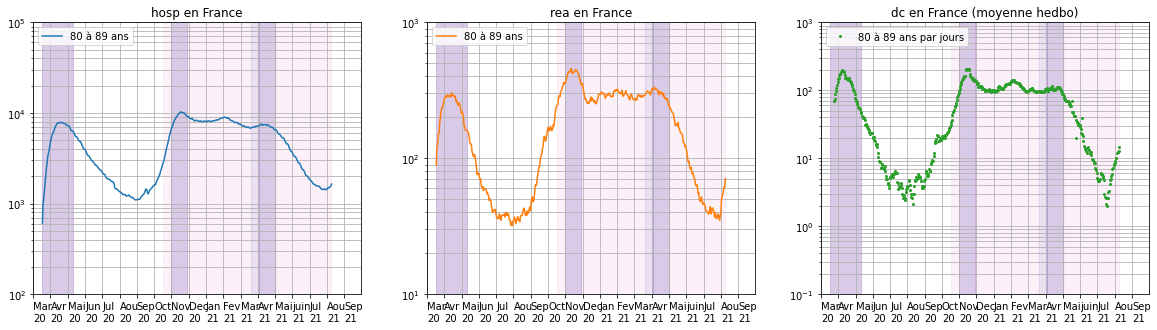


90 à 99+ ans
 Max   hosp :  4764 | 1ère Vague : 4324 | 2ème Vague : 4764 |
 Max   rea  :    45 | 1ère Vague :   31 | 2ème Vague :   45 |
 Max   dc   :   109 | 1ère Vague :  109 | 2ème Vague :  103 |
 Total dc   : 18841 | 1ère Vague:  4066 | 2ème Vague :14775 |


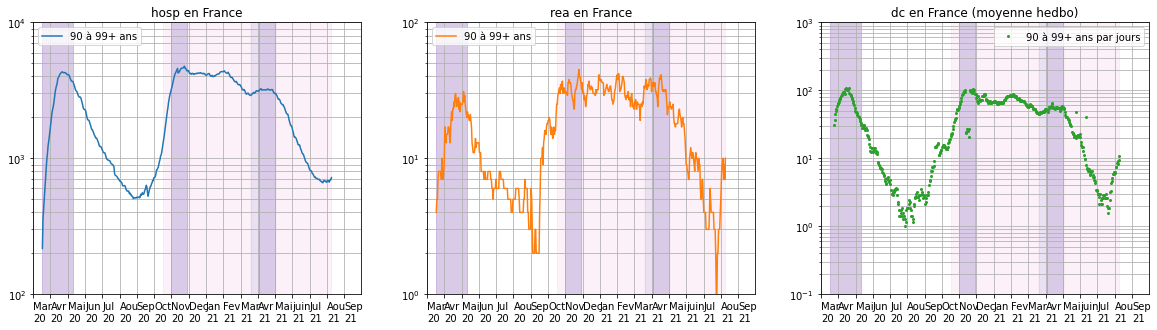

In [33]:
for clage in trancheage:
    DisplayAge(clage)

In [ ]:
CreateReport()
PushCommit()


# Sources de données

https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/

# Méthodologie

- Traitement du fichier de données brutes.
- Représentation des moyennes hebdomadaires comme données de base lissées. 
- Affichage des différentes périodes de couvre-feu et confinement.
- Versionning du dépôt pour la traçabilité et la reproductibilité sur un dépôt public.
- Interface pour les commentaires via github.

# Quelques liens

- Euromomo (EuroMOMO is a European mortality monitoring activity, aiming to detect and measure excess deaths related to seasonal influenza, pandemics and other public health threats.)
https://www.euromomo.eu/graphs-and-maps/

- CépiDc (Centre d'épidémiologie sur les causes médicales de Décès)
https://opendata.idf.inserm.fr/cepidc/covid-19/index.html

- Avis de scientifiques CNRS, INSERM, Institut Pasteur, INRA, Université. Equipe bénévole et indépendante 
https://www.adioscorona.org/

- FranceInfo : "Suivez l’évolution de l'épidémie en France et dans le monde" 
https://www.francetvinfo.fr/sante/maladie/coronavirus/infographies-covid-19-morts-hospitalisations-age-malades-l-evolution-de-l-epidemie-en-france-et-dans-le-monde-en-cartes-et-graphiques.html

- le suivi des variants en angleterre https://www.gov.uk/government/publications/covid-19-variants-genomically-confirmed-case-numbers/

- Un exemple de modélisation épidémique par inférrence https://cloudapps.france-bioinformatique.fr/covidici/

# Quelques reférences bibliographiques
- "Evaluation des stratégies vaccinales COVID-19 avec un modèle mathématique populationnel" Cécile Kiem, Clément Massonnaud, Daniel Levy-Bruhl, Chiara Poletto, Vittoria Colizza, et al. 2020. [pasteur-03087143](https://hal.archives-ouvertes.fr/pasteur-03087143) (23/12/2020)
- "Evolution of outcomes for patients hospitalized during the first SARS-CoV-2 pandemic wave in France. 2020.", Noémie Lefrancq, Juliette Paireau, Nathanaël Hozé, Noémie Courtejoie, Yazdan Yazdanpanah, et al. [hal-02946545](https://hal.archives-ouvertes.fr/hal-02946545) (23/09/2020)
- "Seroprevalence of SARS-CoV-2 among adults in three regions of France following the lockdown and associated risk factors: a multicohort study." [Carrat et al. 2020](https://www.medrxiv.org/content/10.1101/2020.09.16.20195693v1)
- "Ready for a BASE jump? Do not neglect SARS-CoV-2 hospitalization and fatality risks in the middle-aged adult population" [Lapidus et al, 2020](https://www.medrxiv.org/content/10.1101/2020.11.06.20227025v1) (07/11/2020)
- "Estimated date of dominance of VOC-202012/01 strain in France and projected scenarios" [Sabbatini et al, 2021](http://www.epicx-lab.com/uploads/9/6/9/4/9694133/inserm_covid-19-voc_dominance-20210116.pdf) (All reports available [here](https://www.epicx-lab.com/covid-19.htm) )


## **Code Source et données**

- [function.py](function.py)
- [load.py](load.py)
- Données dans le repertoire local /RawData
